In [1]:
# MLP DeepLearning -  MLP 모델을 기반으로 성능 평가 및 시각화 강화
# Dataset 및 DataLoader를 활용한 데이터 처리
# 하이퍼파라미터 튜닝(학습률, 은닉층 크기 등)
# 정확도 계산(accuracy_score), 혼돈 행렬 계산(confusion_matrix), Confusion Matrix 시각화, 정밀도, 재현율, F1-score 등 출력(classification_report)
# 모델 저장 및 불러오기
# 테스트 및 시각화

In [2]:
# 1) 라이브러리 임포터 및 GPU 설정

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Pytorch Version  : ', torch.__version__, 'Device : ', device)

Pytorch Version  :  2.2.2 Device :  cpu


In [3]:
# 2) 커스텀 Dataset 클래스 정의
class BinaryDataset(Dataset):
    def __init__(self):
        self.x_data = torch.tensor( [2,4,6,8,10,12,14,16,18,20], dtype=torch.float32 ).view(-1, 1)
        self.y_data = torch.tensor( [0,0,0,0,0,0,1,1,1,1], dtype=torch.float32 ).view(-1, 1)
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

In [4]:
# 3) DataLoader 생성
dataset = BinaryDataset()
train_loader = DataLoader(dataset=dataset, batch_size=2, shuffle=True)

In [5]:
# 4) 모델 클래스 정의(하이퍼파라미터 튜닝 기능)
class MLPModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=8, output_dim=1):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

In [6]:
# 5) 모델 초기화 및 학습 설정
model = MLPModel(hidden_dim=16).to(device) # 은닉층 크기 튜닝

loss_fn = nn.BCELoss() # 손실함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # 옵티마이저

In [7]:
# 6) 학습 루프
epochs = 1000
for epoch in range(1, epochs + 1):
    model.train() # 학습모드
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch) # 모델 예측
        loss = loss_fn(pred, y_batch) # 손실함수 계산

        # 오차역전차
        optimizer.zero_grad() # 미분 초기화(가중치, 바이어스 파라미터 초기화)
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치, 바이어스 파라미터 업데이트

    if epoch % 100 == 0:
        print(f'[ {epoch:4d} ] Loss: {loss.item():.4f}')


[  100 ] Loss: 0.1748
[  200 ] Loss: 0.3050
[  300 ] Loss: 0.2668
[  400 ] Loss: 0.0000
[  500 ] Loss: 0.0836
[  600 ] Loss: 0.0000
[  700 ] Loss: 0.0002
[  800 ] Loss: 0.0410
[  900 ] Loss: 0.0000
[ 1000 ] Loss: 0.0220


In [8]:
# 7) 예측값 생성 및 평가
model.eval() # 추론 모드
with torch.no_grad(): # 미분 연산하지 않음
    pred = model(dataset.x_data.to(device)) # 모델 예측
    pred_label = (pred > 0.5).float().cpu() # 모델 예측값 변환

# 실제 정답
true_label = dataset.y_data.cpu()

# 정확도 계산
acc = accuracy_score(true_label.numpy(), pred_label.numpy())
print(f'Accuracy : {acc:.4f}')

Accuracy : 1.0000


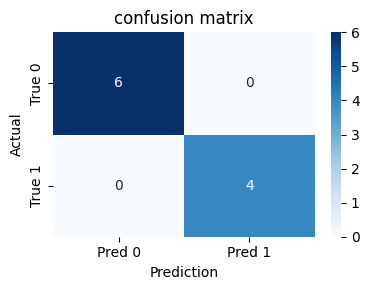

In [9]:
# 8) Confusion Matrix 시각화

# 혼돈 행렬 계산
cm = confusion_matrix(true_label.numpy(), pred_label.numpy())

# 시각화
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title('confusion matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [10]:
# 9) Classification Report 출력

# 정밀도, 재현율, F1-score 등 출력
report = classification_report(true_label.numpy(), pred_label.numpy(), target_names=['class 0', 'class 1'])
print(f'classification_report :\n', report)

classification_report :
               precision    recall  f1-score   support

     class 0       1.00      1.00      1.00         6
     class 1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [11]:
# 10) 모델 저장
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/mlp_model.ckpt')

In [12]:
# 11) 모델 불러오기
loaded_model = MLPModel(hidden_dim=16).to(device)
loaded_model.load_state_dict(torch.load('./models/mlp_model.ckpt'))
loaded_model.eval() # 추론 모드

MLPModel(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

Prediction : 
 tensor([[1.3391e-09],
        [8.8842e-10],
        [8.1209e-10],
        [4.7916e-04],
        [4.0076e-01],
        [1.0000e+00]])
Logical : 
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])


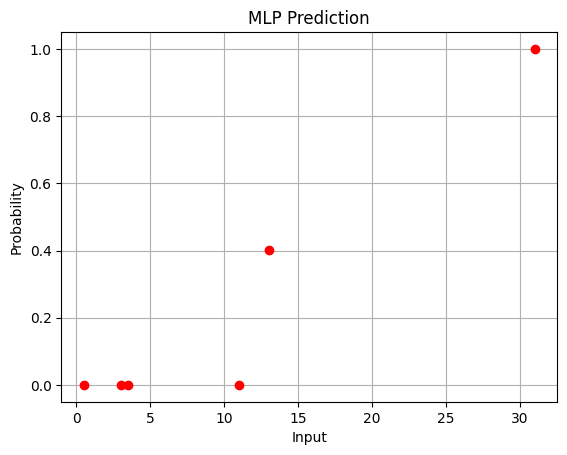

In [13]:
# 12) 테스트 및 시각화
test_data = torch.tensor( [0.5, 3.0, 3.5, 11.0, 13.0, 31.0], dtype=torch.float32 ).view(-1, 1)
with torch.no_grad(): # 미분 연산 하지 않음
    pred = loaded_model(test_data.to(device))
    logical = (pred > 0.5).float()

print('Prediction : \n', pred)
print('Logical : \n', logical)

plt.plot(test_data.cpu().numpy(), pred.cpu().numpy(), 'ro')
plt.title('MLP Prediction')
plt.xlabel('Input')
plt.ylabel('Probability')
plt.grid()
plt.show()